In [1]:
%matplotlib inline

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

from scipy.stats import norm

mpl.rc('font', size=14)

## Signal Generation

Basic code to generate a peaky spectrum on top of a noisy background.

In [2]:
def genpeaks(npeaks):
    x = np.linspace(0, 1000, 1001)
    y = np.zeros(1001, dtype=float)
    for peak in range(npeaks):
        A = np.random.uniform(0.1, 1.)
        mu = np.random.uniform(10., 990.)
        sigma = np.random.uniform(3., 5.)
        y += A * norm.pdf(x, loc=mu, scale=sigma)
    return x, y

def genbkg(x, f):
    return 0.02 * np.sin(f*x)
#     return 0.01 - f*x

def gennoise(x):
    return 0.001*np.random.randn(len(x))

## SNIP Algorithm

Compute the background for a peaky spectrum using the sensitive nonlinear iterative clipping peak (SNIP) algorithm:

M. Morhác, Appl. Spec. 62:2008, 91-106 (https://doi.org/10.1366/000370208783412762)

In [3]:
def snip(x, niter, smoothWindow=None):
    """Implementation of the SNIP algorithm for estimating background
    in a noisy spectrum with peaks."""
    ssize = len(x)
    workspace = np.zeros(2*ssize, dtype=float)
    workspace[0:ssize] = x
    workspace[ssize:] = x
    if smoothWindow is not None:
        if smoothWindow not in [3, 5, 7, 9, 11, 13, 15]:
            raise ValueError('smoothWindow={:d} must be in 3,5,7,..,15'.format(smoothWindow))
        bw = (smoothWindow - 1) // 2

    i = niter
    while i > 0:
        for j in range(i, ssize-i):
            if smoothWindow is None:
                a = workspace[ssize + j]
                b = 0.5*(workspace[ssize + j - i] + workspace[ssize + j + i])
                if b < a:
                    a = b
                workspace[j] = a
            else:
                a = workspace[ssize + j]
                av, men = 0., 0.
                for w in range(j-bw, j+bw+1):
                    if w >= 0 and w < ssize:
                        av += workspace[ssize + w]
                        men += 1
                av /= men

                b, men = 0., 0.
                for w in range(j-i-bw, j-i+bw+1):
                    if w >= 0 and w < ssize:
                        b += workspace[ssize + w]
                        men += 1
                b /= men

                c, men = 0., 0.
                for w in range(j+i-bw, j+i+bw+1):
                    if w >= 0 and w < ssize:
                        c += workspace[ssize + w]
                        men += 1
                c /= men

                b = (b + c) / 2
                if b < a:
                    av = b
                workspace[j] = av

        for j in range(i, ssize-i):
            workspace[ssize + j] = workspace[j]
            
        i -= 1
    return workspace[ssize:]

## Peak Search Algorithm

Search for peaks in source spectrum based on deconvolution method. The response function is generated according to given sigma and deconvolution is carried out. The order of peaks is arranged according to their heights in the spectrum (if desired).

The common problems connected with correct peak identification are:
- non-sensitivity to noise, i.e., only statistically relevant peaks should be identified.
- non-sensitivity of the algorithm to continuous background.
- ability to identify peaks close to the edges of the spectrum region. Usually peak finders fail to detect them.
- resolution, decomposition of Double_tts and multiplets. The algorithm should be able to recognise close positioned peaks.
- ability to identify peaks with different sigma.

Reference:
1. M.A. Mariscotti: A method for identification of peaks in the presence of background and its application to spectrum analysis. NIM 50 (1967), 309-320.
2. M. Morhac;, J. Kliman, V. Matouoek, M. Veselsky, I. Turzo.:Identification of peaks in multidimensional coincidence gamma-ray spectra. NIM, A443 (2000) 108-125.
3. Z.K. Silagadze, A new algorithm for automatic photopeak searches. NIM A 376 (1996), 451.

In [4]:
def search_peak(*args, **kwargs):
    '''Search for peaks in source spectrum based on deconvolution method.
    The response function is generated according to given sigma and deconvolution is carried out.
    The order of peaks is arranged according to their heights in the spectrum (if desired).
    Parameters:
     - source: array-like
         Pointer to the vector of source spectrum.
     - ssize : int 
         Length of source spectrum.
     - sigma : float (default = 3)
         Width of searched peaks. Must be greater than or equal to 1.
     - threshold: float (default = 0.05)
         Threshold value in % for selected peaks,peaks with amplitude less than threshold*highest_peak/100 are ignored.
         Must be positive and less than 100.
     - decon_iterations: int (default = 3)
         Number of iterations in deconvolution operation.
     - max_peak: int (default = 10)
         Maximum number of peaks.
    Keywords Parameters:
     - return_sort: bool, optional (default = False)
         If True, return peak positions sorted by peak height (highest to lowest).
     - return_decon: bool, optional (default = False)
         If True, also return deconvolved spectrum.
    '''
    
    #---------------------------------------
    # Parse arguments
    source, ssize, sigma, threshold, decon_iterations, max_peak = args
    args_dict = {'return_sort':False, 'return_decon':False} 
    for key, value in kwargs.iteritems():
        if args_dict.has_key(key):
            args_dict[key] = value
        else:
            raise AttributeError("Unknow property {}".format(key))
    return_sort, return_decon =  args_dict.values()[::-1]
    
    if sigma < 1:
        raise ValueError("Invalid sigma. Must be greater than or equal to 1.")
    
    if (threshold <= 0) or (threshold >= 100):
        raise ValueError("Invalid threshold. Must be positive and less than 100.")
    
    n_iterations = int(7*sigma+0.5);
    shift = n_iterations
    size_ext = ssize + 2*n_iterations
    
    #----------------------------------------
    # Setting Up
    # conversion for line 2778-2820
    k = int(2*sigma+0.5)
    if k >= 2:
        m0low = 1.*k
        m1low = 1.*k*(k-1)/2
        m2low = 1.*k*(k-1)*(2*k-1)/6 
        l0low = 1.*np.sum(source[:k])
        l1low = 1.*np.sum(np.arange(k)*source[:k])
        detlow = 1.*m0low*m2low-m1low**2

        if detlow != 0:
            l1low = 1.*(-l0low*m1low+l1low*m0low)/detlow
        else:
            l1low = 0.     
    else:
        l1low = 0.

    workspace = np.zeros(7*(ssize+2*n_iterations), dtype = np.float64)
    workspace[size_ext:size_ext+shift] = np.maximum(np.zeros(shift), source[0]+l1low*(np.arange(-shift, 0)))
    workspace[size_ext+shift:size_ext+shift+ssize] = source[:ssize]
    workspace[size_ext+shift+ssize:2*size_ext] = np.maximum(0, source[-1])
    workspace[6*size_ext:7*size_ext] =  workspace[size_ext:2*size_ext]

    #----------------------------------------
    # Deconvolution
    area = 0.
    lh_gold = -1
    posit = 0.
    maximum = 0.

    # conversion for line 2988-3028
    # generate response vector
    lda = np.arange(size_ext)-3*sigma
    lda = lda**2/(2.*sigma**2)
    lda = 1000*np.exp(-lda)
    lda = lda.astype(np.int64)
    if np.sum(lda!=0):
        lh_gold = np.where(lda!=0)[0][-1] + 1
    workspace[:size_ext] = lda
    area = 1.*np.sum(lda)
    posit = np.argmax(lda)
    maximum = 1.*lda[posit]

    workspace[2*size_ext:3*size_ext] = np.abs(workspace[size_ext:2*size_ext])

    # create matrix*a(vector b )
    k = np.minimum(size_ext, lh_gold-1)
    for i in xrange(-k, k+1):
        lda = 0 
        jmin = np.maximum(-i, 0)
        jmax = np.minimum(lh_gold-1-i, lh_gold-1)
        j = np.arange(jmin, jmax+1)
        ldb = workspace[j]
        ldc = workspace[i+j]
        lda = np.sum(ldb*ldc)

        workspace[size_ext+k+i] = lda

    # create vector p 
    i = lh_gold -1
    imin = -i
    imax = size_ext+i-1
    for i in xrange(imin, imax+1):
        lda = 0
        for j in xrange(lh_gold):
            ldb = workspace[j]
            k = i+j
            if (k >=0) and (k < size_ext):
                ldc = workspace[2*size_ext+k]
                lda = lda +ldb*ldc

        workspace[4*size_ext+i-imin] = lda

    # move vector p
    workspace[2*size_ext:2*size_ext+imax-imin+1] = workspace[4*size_ext: 4*size_ext+imax-imin+1]

    # initialization of resulting vector
    workspace[:size_ext] = 1

    # star of iterations
    for lindex in xrange(decon_iterations):
        for i in xrange(size_ext):
            if (np.abs(workspace[2*size_ext+i])>0.00001) and (np.abs(workspace[i]) > 0.00001):
                
                jmin = -1*np.minimum(i, lh_gold - 1)
                jmax = np.minimum(size_ext-1-i, lh_gold - 1)
                
                j = np.arange(jmin, jmax+1)
                ldb = workspace[lh_gold-1+size_ext+jmin:lh_gold+size_ext+jmax]
                ldc = workspace[i+jmin:i+jmax+1]
                lda = np.sum(ldb*ldc)
                
                ldb = workspace[2*size_ext+i]
                if lda != 0:
                    lda = 1.*ldb/lda
                else:
                    lda = 0
                ldb = workspace[i]
                lda = lda*ldb
                workspace[3*size_ext+i] = lda
        workspace[:size_ext] =  workspace[3*size_ext:4*size_ext]

    # shifting resulting spectrum
    for i in xrange(size_ext):
        lda = workspace[i]
        j =  i + posit
        j = j % size_ext
        workspace[size_ext+j] = lda

    # writing back resulting spectrum
    maximum = 0.
    maximum_decon = 0. 
    
    j = lh_gold - 1
    workspace[shift:shift+ssize] = area*workspace[size_ext+shift+j:size_ext+shift+ssize+j]
    workspace[:shift] = 0.
    workspace[shift+ssize:size_ext-j] = 0.
    maximum_decon = np.max(workspace[shift:shift+ssize])
    maximum = np.max(workspace[6*size_ext+shift:6*size_ext+shift+ssize])

    lda = np.minimum(1., threshold)/100

    #--------------------------------
    # Peak Searching
    peak_pos = np.zeros(max_peak)-1
    peak_index = 0 
    for i in xrange(1, size_ext-1):
        if (workspace[i] <= workspace[i-1]) or (workspace[i] <= workspace[i+1]):
            continue
        if (workspace[i] <= lda*maximum_decon) or (workspace[6*size_ext+i] <= threshold*maximum/100.):
            continue    
        if (i < shift) or (i >= ssize+shift):
            continue
        j = np.arange(i-1, i+2)
        a = 1.*np.sum((j-shift)*workspace[j])
        b = np.sum(workspace[j])
        a = a/b
        if a < 0:
            a = 0
        if a >= ssize:
            a = ssize-1
            
        peak_pos[peak_index] = a
        peak_index +=1
        if peak_index >= max_peak:
            break
        
    peak_pos = peak_pos[peak_pos != -1]
    
    # convert to index
    # get the maximum of the floor and the ceil index value
    peak_ceil  = np.ceil(peak_pos).astype(np.int64)  # ceiling index
    peak_floor = np.floor(peak_pos).astype(np.int64) # floor index
    peak_pos = np.copy(peak_floor)
    peak_pos[source[peak_ceil] > source[peak_floor]] = peak_ceil[source[peak_ceil] > source[peak_floor]]
    
    # sort peak by height
    if return_sort:
        peak_pos = peak_pos[np.argsort(source[peak_pos])][::-1]
    
    # return deconvolved spectrum
    if return_decon:
        decon = workspace[shift:shift+ssize]
        return peak_pos, decon
    
    return peak_pos

Generate a random spectrum with a sinusoidal background.

In [5]:
x, y = genpeaks(10)
bkg = genbkg(x, 0.005)
noise = gennoise(x)

y += bkg + noise

Compute the background with SNIP, tuning the number of iterations and using smoothing (or not).

Generally one wants the number of iterations to be about the width of the typical peak.

Note that without smoothing the background estimate tends to be biased in the presence of noise since it will fit the lower envelope of the statistical fluctuations in the spectrum. Smoothing will correct most of the bias but one has to watch for overfitting.

The plots below show the bias present in the background-subtracted data if smoothing is not applied to the noisy spectrum.

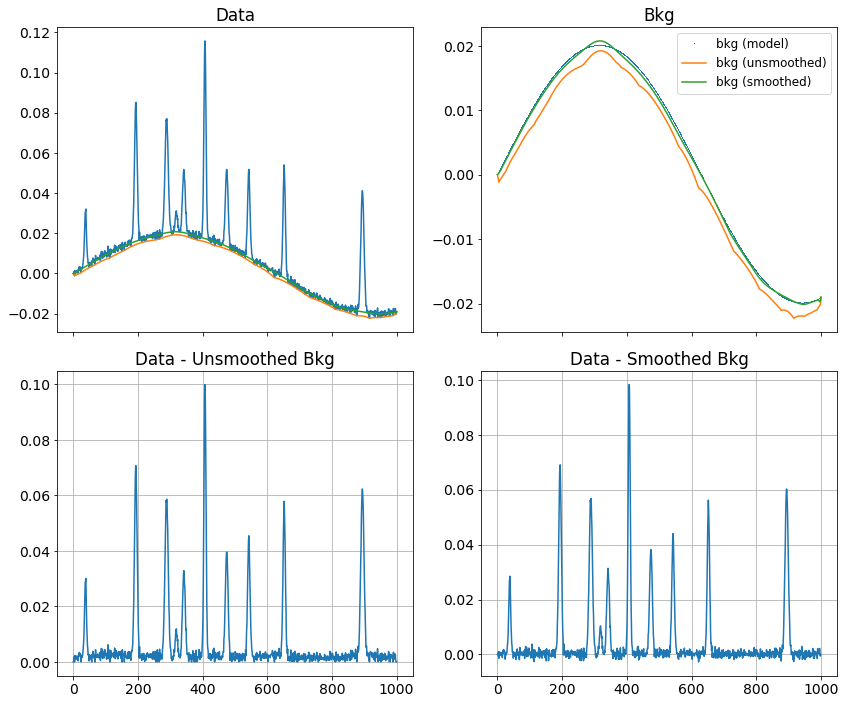

In [6]:
b  = snip(y, 20)
bs = snip(y, 18, 5)

fig, axes = plt.subplots(2, 2, figsize=(12,10), sharex=True)
ax1, ax2, ax3, ax4 = axes.flatten()
ax1.plot(x, y)
ax1.plot(x, b)
ax1.plot(x, bs)
ax1.set(title='Data')
ax2.plot(x, bkg, ',', label='bkg (model)')
ax2.plot(x, b, label='bkg (unsmoothed)')
ax2.plot(x, bs, label='bkg (smoothed)')
ax2.legend(fontsize=12)
ax2.set(title='Bkg')
ax3.plot(x, y-b)
ax3.grid()
ax3.set(title='Data - Unsmoothed Bkg')
ax4.plot(x, y-bs)
ax4.set(title='Data - Smoothed Bkg')
ax4.grid()
fig.tight_layout();

### FDR for threshold finding
Method works only for a background with $\sigma$=1. So we need to scale the bin_edges

FDR says the threshold needs to be at 0.004140295280063586


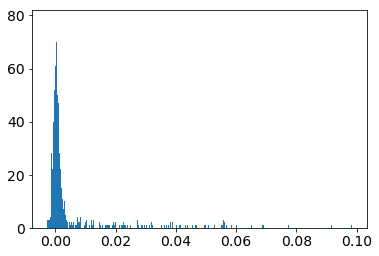

In [32]:
import matplotlib.pyplot as plt
import math
from scipy.optimize import curve_fit

def calcParams(counts, bin_edges, q, isConservative=True):
    nbins = len(counts)
    params = np.zeros(4)
    probHit = 0
    m = 0
    for i in range(nbins):
        m = m + counts[i]
    if isConservative:
        c = math.log(m)+0.5722
    else:
        c = 1
    for i in range(nbins-1, 0, -1):
        if ( counts[i] == 0 ):
            continue
        events = np.sum(counts[i:nbins])
        param  = (q*events)/(c*m)
        compare= norm.cdf(-bin_edges[i])
        if (param<compare):
            #print(i, c, m, counts[i], q, events, param, compare)
            return bin_edges[i]

def gauss_function(x, a, sigma):
    return a*np.exp(-(x)**2/(2*sigma**2))
        
def scale_histogram(counts, bin_edges):
    # fit a gaussian to the negative side of the distribution
    # then using the sigma, calculate the scaling factor for x-axis
    scale = 1
    for i in range(len(counts)):
        if bin_edges[i]>0:
            last_idx = (i-1)*2
            break
    popt, pcov = curve_fit(gauss_function, bin_edges[:last_idx], counts[:last_idx], p0 = [1, 0.001])
    scale = 1./popt[1]
    return scale
    
counts, bin_edges, patches = plt.hist(y-bs, bins=500)
counts = counts/np.sum(counts)
scale = scale_histogram(counts, bin_edges)
threshold = (calcParams(counts, bin_edges*scale, 0.00001)/scale)
print("FDR says the threshold needs to be at {}".format(threshold))
#print(calcParams(counts, bin_edges*scale, 0.005, isConservative=False)/scale)

Peak Searching

In [18]:
source = y-bs
ssize  = len(source)
sigma  = 1.0
decon_iterations = 10
#threshold = 5
max_peak = 30

#print(max_peak)
peak_pos, decon = search_peak(source, ssize, sigma, threshold, decon_iterations, max_peak, return_decon = True)

30


AttributeError: 'dict' object has no attribute 'iteritems'

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(13, 5))
ax1, ax2 = axes

ax1.plot(x, source)
ax1.scatter(peak_pos, source[peak_pos], color = 'r')
ax1.set(title = 'Data')

ax2.plot(x, decon)
ax2.set(title='Deconvolved Data')

fig.tight_layout()